# **Decision Trees**
### Sourlantzis Dimitrios 9868
### Kyrgiafini Angeli Dimitra 9685

In [2]:
# Imports needed 
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
import math 


# **PART - A**

In the first part we use the function DecisionTreeClassifier from sklearn library. The first half of the samples is used to train the decision tree and the second half to evaluate it. The first half of the data are used to train the trees and the second half to test them. Trees with depth 1 to 100 are created and the one with the highest testing accuracy is finally kept. It is clear that there is a peak in depth 4 or 5 and after that accuracy decreases dramatically and does not have a significant pattern. For the tree with the depth that achieved the highest accuracy, a contour plot is created. In this plot we can see the decision surface for each class and the classiication of the testing data. We can observe that the result is not satisfying enough. 

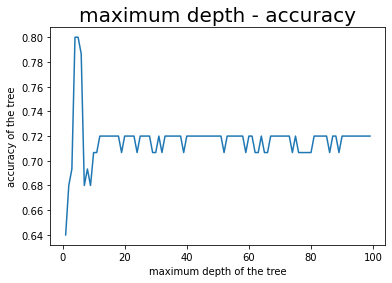

Depth with best accuracy is: 4
Best accuracy score is: 0.8 



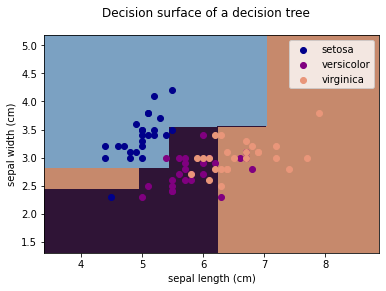

In [3]:
MaxDepthToTry = 100
treeDepths = [None] * MaxDepthToTry
treeScores = [None] * MaxDepthToTry
#define training and test datasets
iris = load_iris()
X_train = np.append(iris.data[:25, 0:2],iris.data[50:75, 0:2],axis=0) # petal length and width
X_train = np.append(X_train,iris.data[100:125, 0:2],axis=0)
y_train = np.append(iris.target[0:25],[iris.target[50:75],iris.target[100:125]])

X_test = np.append(iris.data[25:50, 0:2],iris.data[75:100, 0:2],axis=0) # petal length and width
X_test = np.append(X_test,iris.data[-25:, 0:2],axis=0)
y_test = np.append(iris.target[25:50],[iris.target[75:100],iris.target[-25:]])


#test for different maximum depths
bestTreeAccuracy = 0
bestTreeDepth = 0
for i in range(1,MaxDepthToTry):
  tree_clf = DecisionTreeClassifier(max_depth=i)
  tree_clf.fit(X_train, y_train)
  score = tree_clf.score(X_test, y_test)
  treeDepths[i-1] = i
  treeScores[i-1] = score
  if score > bestTreeAccuracy :
    bestTreeAccuracy = score
    bestTreeDepth = i 

#plot maxDepth - accuracy
plt.plot(treeDepths,treeScores)
plt.xlabel('maximum depth of the tree') 
plt.ylabel('accuracy of the tree') 
plt.title("maximum depth - accuracy", fontsize = 20)
plt.show()

print("Depth with best accuracy is:",bestTreeDepth)
print("Best accuracy score is:",bestTreeAccuracy,"\n")

#make a tree with the optimal depth
tree_clf = DecisionTreeClassifier(max_depth=bestTreeDepth)
a = tree_clf.fit(X_train, y_train)
score = tree_clf.score(X_test, y_test)

#plot the decision surface and the classified samples
plot_step = 0.02
plot_colors = ('darkblue','purple','darksalmon')
idx = np.arange(X_test.shape[0])
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, 2,cmap=plt.cm.twilight)
cs = plt.contourf(xx, yy, Z, 2,cmap=plt.cm.twilight)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.axis("tight")
plt.suptitle("Decision surface of a decision tree")
for i, color in zip(range(3), plot_colors):
        idx = np.where(y_test == i)
        plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)
plt.legend()
plt.show()
#print(Z)


# **PART - B**
In this part we are asked to implement a random forest classifier. This type of classifier consists of a number of trees each of which is trained with a different subset of data. The decision of the forest is the decision of the majority of its trees. In our case each forest consists of 100 trees of the same depth. As in part A, we use the first half of the data to train the forests and the second half to test them. In order to create different subsets to train each tree in the forest we use bootstrap technique. We take n$\cdotγ$ distinct samples, where n is the number of samples in the training dataset. From this n$\cdotγ$ samples we pool n samples with replacement as the resampling technique. This is the training dataset for an individual tree.
In this way we create multiple datasets and each tree is different from the others in the forest, this can provide as with greater accuracy.

In the first cell the functions that will be used are declared. A class "Forest" is created with the useful functions as methods for a more cleare view of the algorithm.
 

In [7]:
#declare custom functions used in this part
def chooseBestForest(numberOfTrees,gama,maxDepth):

  storeForests = [None] * maxDepth
  #create forest with different tree depths
  bestForestScore = 0
  bestForestDepth = 0
  depths = [None] * maxDepth
  scores = [None] * maxDepth
  for k in range (1,maxDepth):
    forestInstance = Forest(numberOfTrees,gama,X_train,y_train,k)
    forest = forestInstance.getForest()
    score = forestInstance.evaluateForest(X_test,y_test)
    depths[k-1] = k
    scores[k-1] = score
    storeForests[k-1] = forestInstance
    if score > bestForestScore :
      bestForestScore = score
      bestForestDepth = k
  bestForest = storeForests[bestForestDepth - 1]
  return bestForestScore,bestForestDepth,bestForest,depths,scores

class Forest:

    def __init__(self,numberOfTrees,gama,X_train,y_train,depthOfTrees):
        self.numberOfTrees = numberOfTrees
        self.forest = [None] * numberOfTrees
        randomDataSize = math.floor(75*gama)
        for i in range (0,numberOfTrees):
          #create random tree
          self.forest[i] = DecisionTreeClassifier(max_depth = depthOfTrees)

          #####################combine data and target for the training Dataset#####################
          y_train_transpose = y_train.reshape((-1, 1))
          #ctreate array with target data appended in a 3rd column
          dataPool = np.append(X_train,y_train_transpose,axis=1)
          #take from the data Pool half distinct of the training data
          distinctData = dataPool[np.random.choice(dataPool.shape[0], randomDataSize, replace=False), :]

          #take number of sapmles equal to the training dataset but pool them from the random half distinct data extraced above
          sampleForThisTree = distinctData[np.random.randint(distinctData.shape[0], size = 75), :]
          randomTrainData = sampleForThisTree[:,:2]
          randomTrainTarget = sampleForThisTree[:,2:]

          #train the tree with the random data
          self.forest[i].fit(randomTrainData, randomTrainTarget)
          #lololo = dataPool[np.random.choice(dataPool.shape[0], 75, replace=False), :]
          #forest[i].fit(lololo[:,:2], lololo[:,2:])


    def getForest(self):
      
      return self.forest

    def evaluateForest(self,X_test,y_test):
      scores = [None] * self.numberOfTrees
      for i in range(0,self.numberOfTrees):
        scores[i] = self.forest[i].score(X_train, y_test) 
      forestScore = np.mean(scores)
      return forestScore

    def forestPredicts1sample(self,data):
      counters = [0] * 3
      for i in range (0,self.numberOfTrees):
        a = self.forest[i].predict(data)
        if (a == 0):
          counters[0] += 1
        if (a == 1):
          counters[1] += 1
        if (a == 2):
          counters[2] += 1
      decisionClass = counters.index(max(counters))
      return decisionClass

    def forestPredicts(self,sepalLengthGrid,sepalWidthGrid):
      width = len(sepalLengthGrid)
      height = len(sepalWidthGrid)
      decisionMatrix = np.zeros((height, width))
      for i in range(0,height):
        for j in range(0,width):
          data = np.array([[sepalLengthGrid[j]], [sepalWidthGrid[i]]]).T 
          decisionMatrix[i,j] = self.forestPredicts1sample(data)
      return decisionMatrix

  


## 1. depth - accuracy evaluation 
In this query we explore the accuracy of the forest by creating and evaluating forests with trees of different depth. Each forest consists of 100 trees and the percentage of data taken form the training data to train each tree is $\gamma=50$%. We can observe that for forests with tree depth 10 and higher classification accuracy remains almost the same and it is slightly lower than part A. If we run the code multiple times we wiil notice that the best accuracy may be achieved by any forest with depth 10 to 90. This can be caused by the fact that we only use half of the training dataset we use in part A, for each tree. Also with more tree depth the accuracy of the forest does not decrease and does not have a random behavior as in part A. This is caused by the fact that mny trees contribute in the dicision of the forest making its decisions less random.

Depth with best accuracy is: 46
Best accuracy score is: 0.7763999999999999 



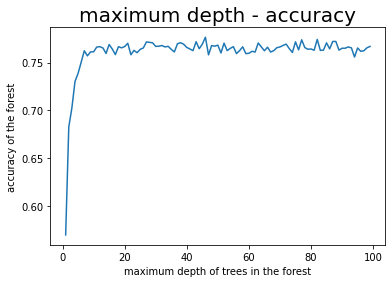

In [22]:
numberOfTrees =100
gama = 0.5
maxDepth = 100

bestForestScore,bestForestDepth,bestForest,depths,scores = chooseBestForest(numberOfTrees,gama,maxDepth)
#plot maxDepth - accuracy
plt.plot(depths,scores)
plt.xlabel('maximum depth of trees in the forest') 
plt.ylabel('accuracy of the forest') 
plt.title("maximum depth - accuracy", fontsize = 20)

print("Depth with best accuracy is:",bestForestDepth)
print("Best accuracy score is:",bestForestScore,"\n")

## 2. plot decision surface
The plot of decision surface for the forest with the best result is similar to the plot in part A. But in this case the decision boundaries are much less solid than in part A. For example, in part A, there is a region on the decision surface of the third class in which test data of the second class exist. In this part, with the forest classifier, in this spot a decision surface for the second class has been created.

Depth with best accuracy is: 69
Best accuracy score is: 0.7774666666666668 



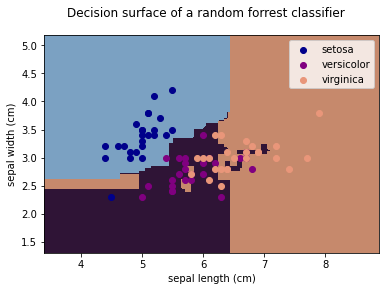

In [113]:
myPlotStep = 0.02

#plot the decision surface of forest
xx = np.arange(x_min, x_max, myPlotStep)
yy = np.arange(y_min, y_max, myPlotStep)
Z = bestForest.forestPredicts(xx,yy)
xx, yy = np.meshgrid(np.arange(x_min, x_max, myPlotStep),np.arange(y_min, y_max, myPlotStep))
cs = plt.contourf(xx, yy, Z, 2,cmap=plt.cm.twilight)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.axis("tight")
plt.suptitle("Decision surface of a random forrest classifier")
for i, color in zip(range(3), plot_colors):
        idx = np.where(y_test == i)
        plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)
plt.legend()

print("Depth with best accuracy is:",bestForestDepth)
print("Best accuracy score is:",bestForestScore,"\n")


## 3. Importance of $γ$ factor
We observe that the higher the value of gamma, the better the accuracy of the forests. This is expected, because in order to create a training dataset for the trees, we pool from a fraction of the original training dataset with replacement. The higher this fraction is the more diverse the training dataset wiil be, resulting in better training for an individual tree. The fact that we pool with replacement, creates diversity between the training datasets os the trees making the whole forest better trained.

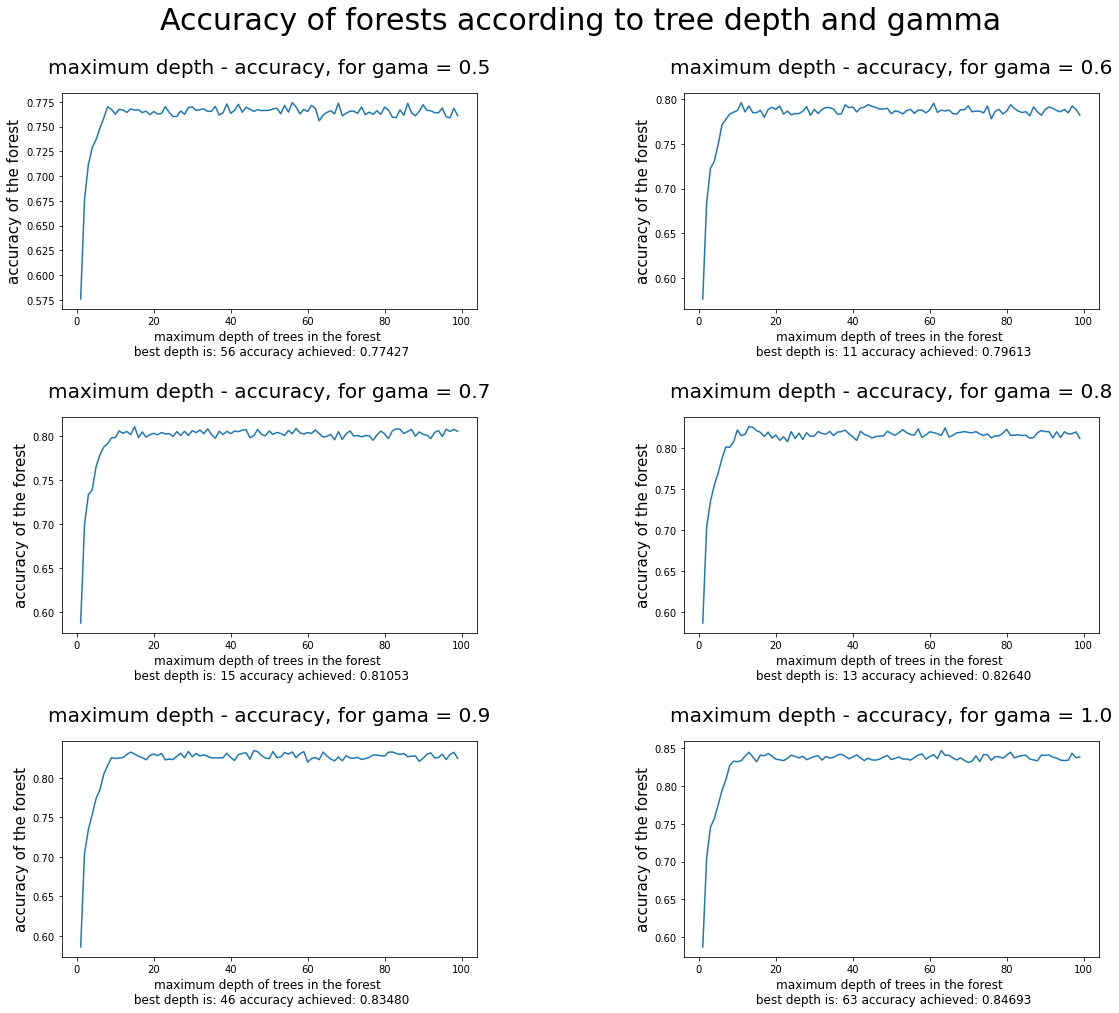

In [29]:
#make plots for different gammas

#gamas that are going to be examined
gamas = [0.5,0.6,0.7,0.8,0.9,1]

#stuff for the plots
strTitle = "maximum depth - accuracy, for gama = "
fig = plt.figure(figsize = (18,15))
fig.tight_layout(pad = 10.0)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.5)
fig.suptitle("Accuracy of forests according to tree depth and gamma",fontsize = 30)
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)
subplots = [ax1,ax2,ax3,ax4,ax5,ax6]

#plot the plots
for i in range(0,6):
  bestForest_score,bestForest_depth,best_forest,forestDepths,forestScores = chooseBestForest(numberOfTrees,gamas[i],maxDepth)

  subplots[i].plot(forestDepths,forestScores)
  #subplots[i].set_xlabel('maximum depth of trees in the forest \n ja',fontsize = 15)
  subplots[i].set_xlabel("maximum depth of trees in the forest \n best depth is: %d accuracy achieved: %.5f" %(bestForest_depth, bestForest_score),fontsize = 12)
  subplots[i].set_ylabel('accuracy of the forest',fontsize = 15)
  subplots[i].set_title(f'{strTitle}{gamas[i]:.1f}', fontsize = 20,pad = 20)
